In [17]:
import os
import time
import math
import random
from datetime import datetime

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import gym

import tensorflow as tf
from tensorflow import keras

from DQNAgent import DQNAgent
from TransitionTable import TransitionTable

In [30]:
# hyperparamters
minibatch_size = 32  # number of training cases over which each stochastic gradient descent (SGD) update is computed
replay_memory_size = 1024  # SGD updates are sampled from this number of most recent frames
agent_history_length = 4  # the number of most recent frames experienced by agent that are given as input to the Q network
target_network_update_frequency = 10_000  # the freuquency (measured in the number of parameter updates) with which the target netwrok is updated (this corresponds to the parameter C from Algorithm 1)
discount_factor = 0.99  # discount factor gamma used in the Q-learning update
# action_repeat = 4  # repeat each action selected by the agent this many times. Using a value of 4 results in the agent seeing only every 4 input frame
update_frequency = 4  # the number of actions selected by the agent between successive SGD updates. Using a value of 4 results in the agent selecting 4 actions between each pair of successive updates
learning_rate = 0.00025  # the learning rate used by RMSProp
# gradient_momentum = 0.95  # squared gradient (denominator) momentum used by RMSProp
# min_squared_gradient = 0.01  # constant added to the squared gradient in the denominator of the RMSProp update
inital_exploration = 1.0  # initial value of epsilon in epsilon-greedy exploration
final_exploration = 0.1  # final value of epsilon in epsilon-greedy exploration
final_exploration_frame = 1_000_000  # the number of frames over which the initial value of epsilon is linearly annealed to its final value
replay_start_size = 20_000  # a uniform random policy is run for this number of frames before learning starts and the resulting experience is used to populate the replay memory
# no_op_max = 30  # maximum number of "do nothing" actions to be performed by agent at the start of an episode

env_name = 'Breakout-v0'
# general setup
env = gym.make(env_name)
n_actions = env.action_space.n

model_fn = 'Breakout-v0_model_20190615_144028.h5'
model = keras.models.load_model(model_fn)
agent = DQNAgent(
    n_actions=n_actions,
    ep_start=inital_exploration,
    ep_end=final_exploration,
    ep_endt=final_exploration_frame,
    lr=learning_rate,
    minibatch_size=minibatch_size,
    discount=discount_factor,
    update_freq=update_frequency,
    learn_start=replay_start_size,
    replay_memory=replay_memory_size,
    hist_len=agent_history_length,
    max_reward=1,
    min_reward=-1,
    network=model,
)

In [31]:
num_steps = 10_000
step = 0

screen = env.reset()
reward = 0
terminal = 0

train_start = time.time()
for step in tqdm(range(num_steps)):
    action = agent.perceive(
        reward, screen, terminal,
#         testing=True,
        # testing_ep=0.2,
#         testing_ep=0,
    )

    # game over? get next game!
    if not terminal:
        observation = env.step(action)
#         env.render()
        screen, reward, done, info = observation
        if done:
            terminal = 1
    else:
        screen = env.reset()
        reward = 0
        terminal = 0

100%|███████████████████████████████████| 10000/10000 [00:33<00:00, 302.60it/s]


In [32]:
model.layers

In [33]:
conv1 = model.layers[0]

In [34]:
conv1

In [35]:
type(conv1)

tensorflow.python.keras.layers.convolutional.Conv2D

In [66]:
layer_outputs = [layer.output for layer in model.layers[:3]]
layer_outputs

[<tf.Tensor 'conv2d_4/Relu:0' shape=(None, 32, 25, 19) dtype=float32>,
 <tf.Tensor 'conv2d_1_2/Relu:0' shape=(None, 15, 11, 64) dtype=float32>,
 <tf.Tensor 'conv2d_2_2/Relu:0' shape=(None, 13, 9, 64) dtype=float32>]

In [67]:
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [68]:
activation_model

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 25, 19)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 11, 64)        19520     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 7488)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3834368   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 3,901,092
Trainable params: 3,901,092
Non-trainable params: 0
______________________________________________

In [69]:
activation_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 4, 105, 80)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 25, 19)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 11, 64)        19520     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 64)         36928     
Total params: 64,672
Trainable params: 64,672
Non-trainable params: 0
_________________________________________________________________


In [70]:
s, a, r, s2, term = agent.transitions.sample()

In [71]:
s.shape

(1, 4, 105, 80)

In [72]:
fullstate = s[0]
fullstate.shape

(4, 105, 80)

In [73]:
for i in range(len(fullstate)):
    frame = fullstate[i, :, :]
    print(frame.shape)

(105, 80)
(105, 80)
(105, 80)
(105, 80)


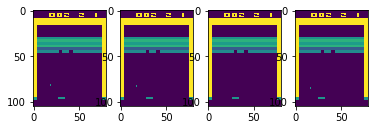

In [74]:
for i in range(len(fullstate)):
    plt.subplot(1, len(fullstate), i+1)
    frame = fullstate[i, :, :]
#     plt.matshow(fullstate[i, :, :], cmap='viridis')
    plt.imshow(frame, cmap='viridis')

In [75]:
activations = activation_model.predict(s)

In [76]:
len(activations)

3

In [77]:
for layer_activation in activations:
    print(layer_activation.shape)

(1, 32, 25, 19)
(1, 15, 11, 64)
(1, 13, 9, 64)


In [78]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 32, 25, 19)

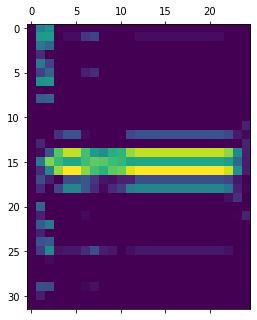

In [79]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

## Plot using `matplotlib`

c:\users\shioko\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


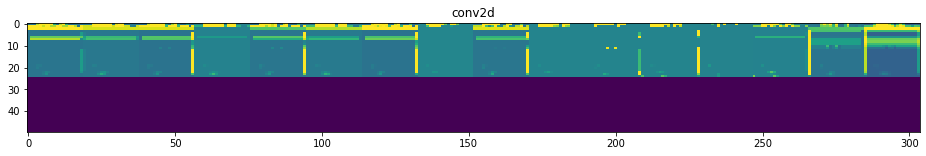

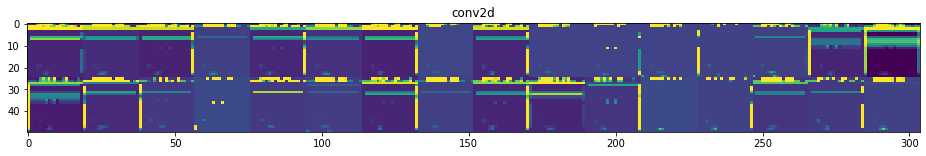

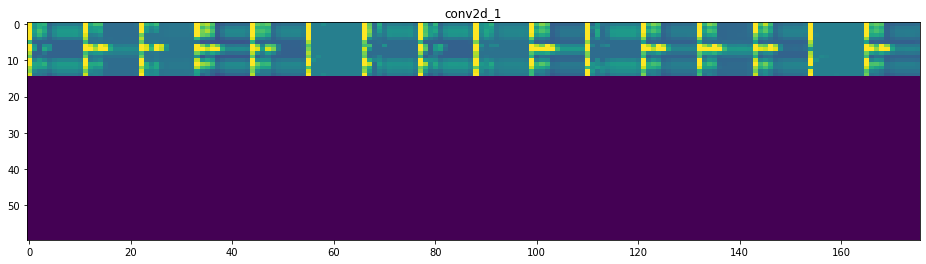

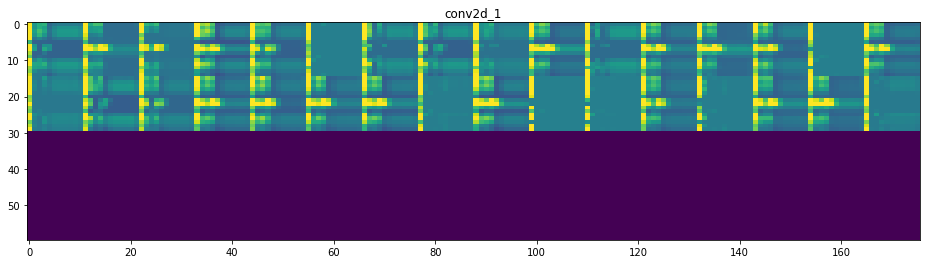

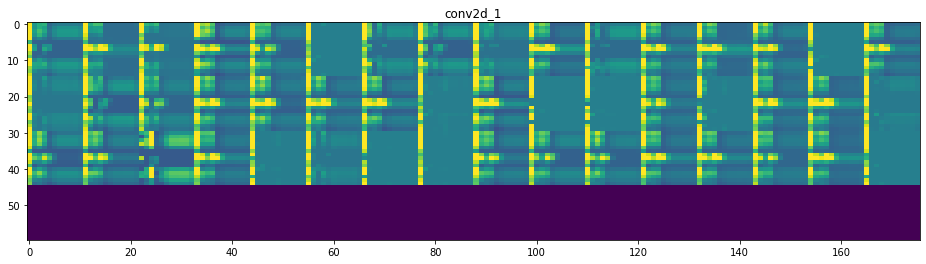

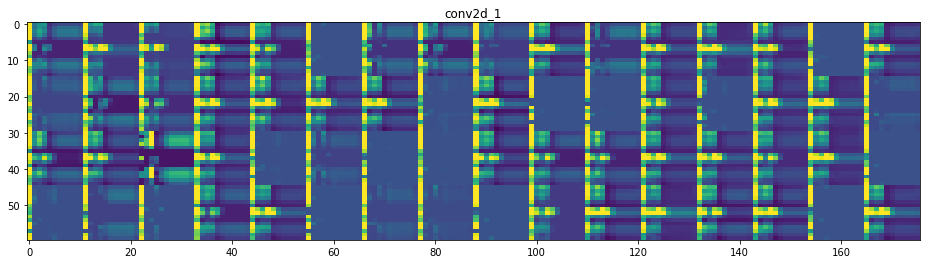

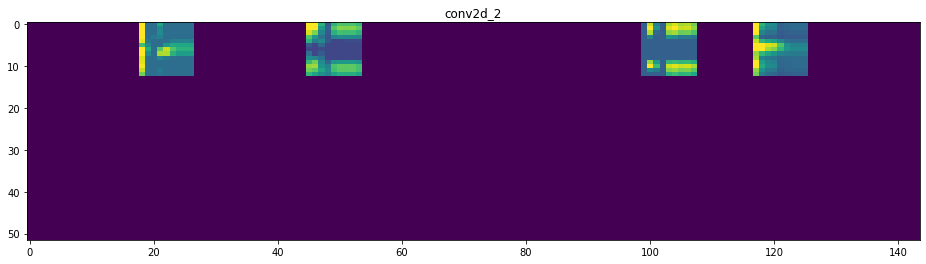

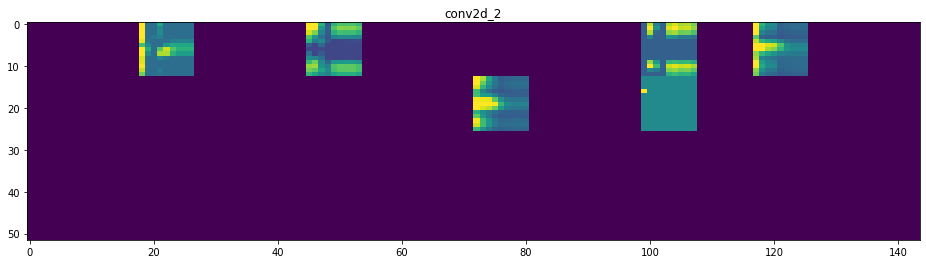

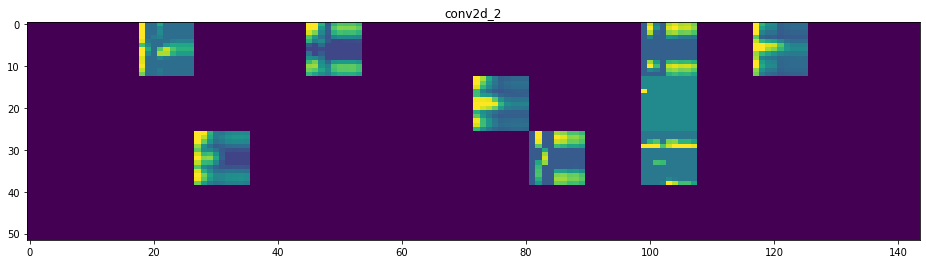

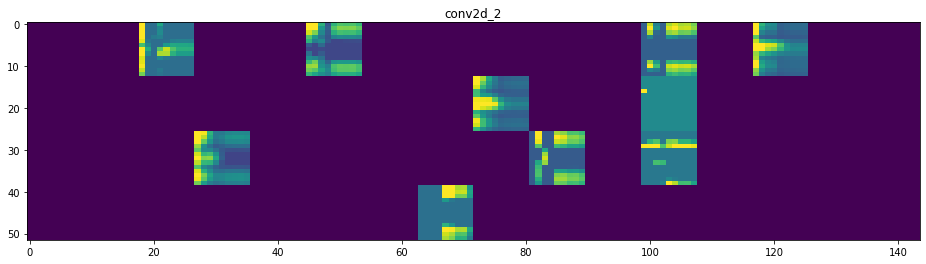

In [87]:
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

for idx, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)): # displays the feature maps
    if idx == 0: # the first layers feature map has shape(1, n_features, height, width)
        n_features = layer_activation.shape[1]
        size = layer_activation.shape[2:4]
    else:
        n_features = layer_activation.shape[-1] # the feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1:3]
    n_rows = n_features // images_per_row # tiles the activation channels in this matrix
    display_grid = np.zeros(shape=(size[0]*n_rows, size[1] * images_per_row))
    for row in range(n_rows):
        for col in range(images_per_row):
            if idx == 0:
                channel_image = layer_activation[0, row * images_per_row + col, :, :]
            else:
                channel_image = layer_activation[0, :, :, row * images_per_row + col]
                # post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype(np.uint8)
            # displays the grid
            
            display_grid[
                row * size[0]: (row + 1) * size[0], 
                col * size[1]: (col + 1) * size[1]
            ] = channel_image
        height_scale = 1.0 / size[0]
        width_scale = 1.0 / size[1]
        plt.figure(figsize=(width_scale * display_grid.shape[1], height_scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
            

## Plot using `IPython.display`

In [88]:
import IPython.display as display

In [99]:
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

for idx, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)): # displays the feature maps
    if idx == 0: # the first layers feature map has shape(1, n_features, height, width)
        n_features = layer_activation.shape[1]
        size = layer_activation.shape[2:4]
    else:
        n_features = layer_activation.shape[-1] # the feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1:3]
    n_rows = math.ceil(n_features / images_per_row) # tiles the activation channels in this matrix
    display_grid = np.zeros(shape=(size[0]*n_rows, size[1] * images_per_row))
    for row in range(n_rows):
        for col in range(images_per_row):
            if idx == 0:
                channel_image = layer_activation[0, row * images_per_row + col, :, :]
            else:
                channel_image = layer_activation[0, :, :, row * images_per_row + col]
                # post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype(np.uint8)

            # displays the grid
            display_grid[
                row * size[0]: (row + 1) * size[0], 
                col * size[1]: (col + 1) * size[1]
            ] = channel_image
        
    fig_fname j = f'{layer_name}_display_grid.png'
    plt.imsave(fig_fname, display_grid, cmap='viridis')
    display.display(display.HTML(layer_name))
#         display.display(display.Image(filename=fig_fname))
    img_html = f'<img style="width: 100%; image-rendering: pixelated;" src="{fig_fname}">'
    display.display(display.HTML(img_html))